# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

##### From the Materials and Method : 
- GOAL : Goal was to increase efficiency of directed campaigns for long-term deposit subscriptions by reducing the number of contacts to do.
- the Lift is the most commonly used metric to evaluate prediction models (Coppock 2002). In particular, the cumulative Lift curve is a percentage graph that divides the population into deciles, in which population members are placed based on their predicted probability of response. The responder deciles are sorted, with the highest responders are put on the first decile.
- 17 Campaigns between May 2008 and Nov 2010. Total of 79354 contacts.


### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

In [6]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [7]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [ ]:
df['campaign'].value_counts()

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [8]:
df['education'].value_counts()

education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: count, dtype: int64

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

## Goal
Increase efficiency of directed campaigns for long term deposit subscriptions by optimizing the number of contacts made.

The result is not to specify the efficiency % or what the optimal / minimum # of contacts are, but more to identify which customer profile / type is better suited for the compaign.

Target Outcome (Dependent variable) : Is represented as 'y'. Value 'yes' indicates cient has subscribed to long term deposity. 'no' is the opposite
Independent Variables : Various data elements captured as part of the campaign as well as from internal bank records are listed above.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [10]:
# proportion of yes and no in the target variable
df['y'].value_counts()
# --- NOTE : Output clearly shows Target variable is imbalanced and hence we may need to stratify our sampling

y
no     36548
yes     4640
Name: count, dtype: int64

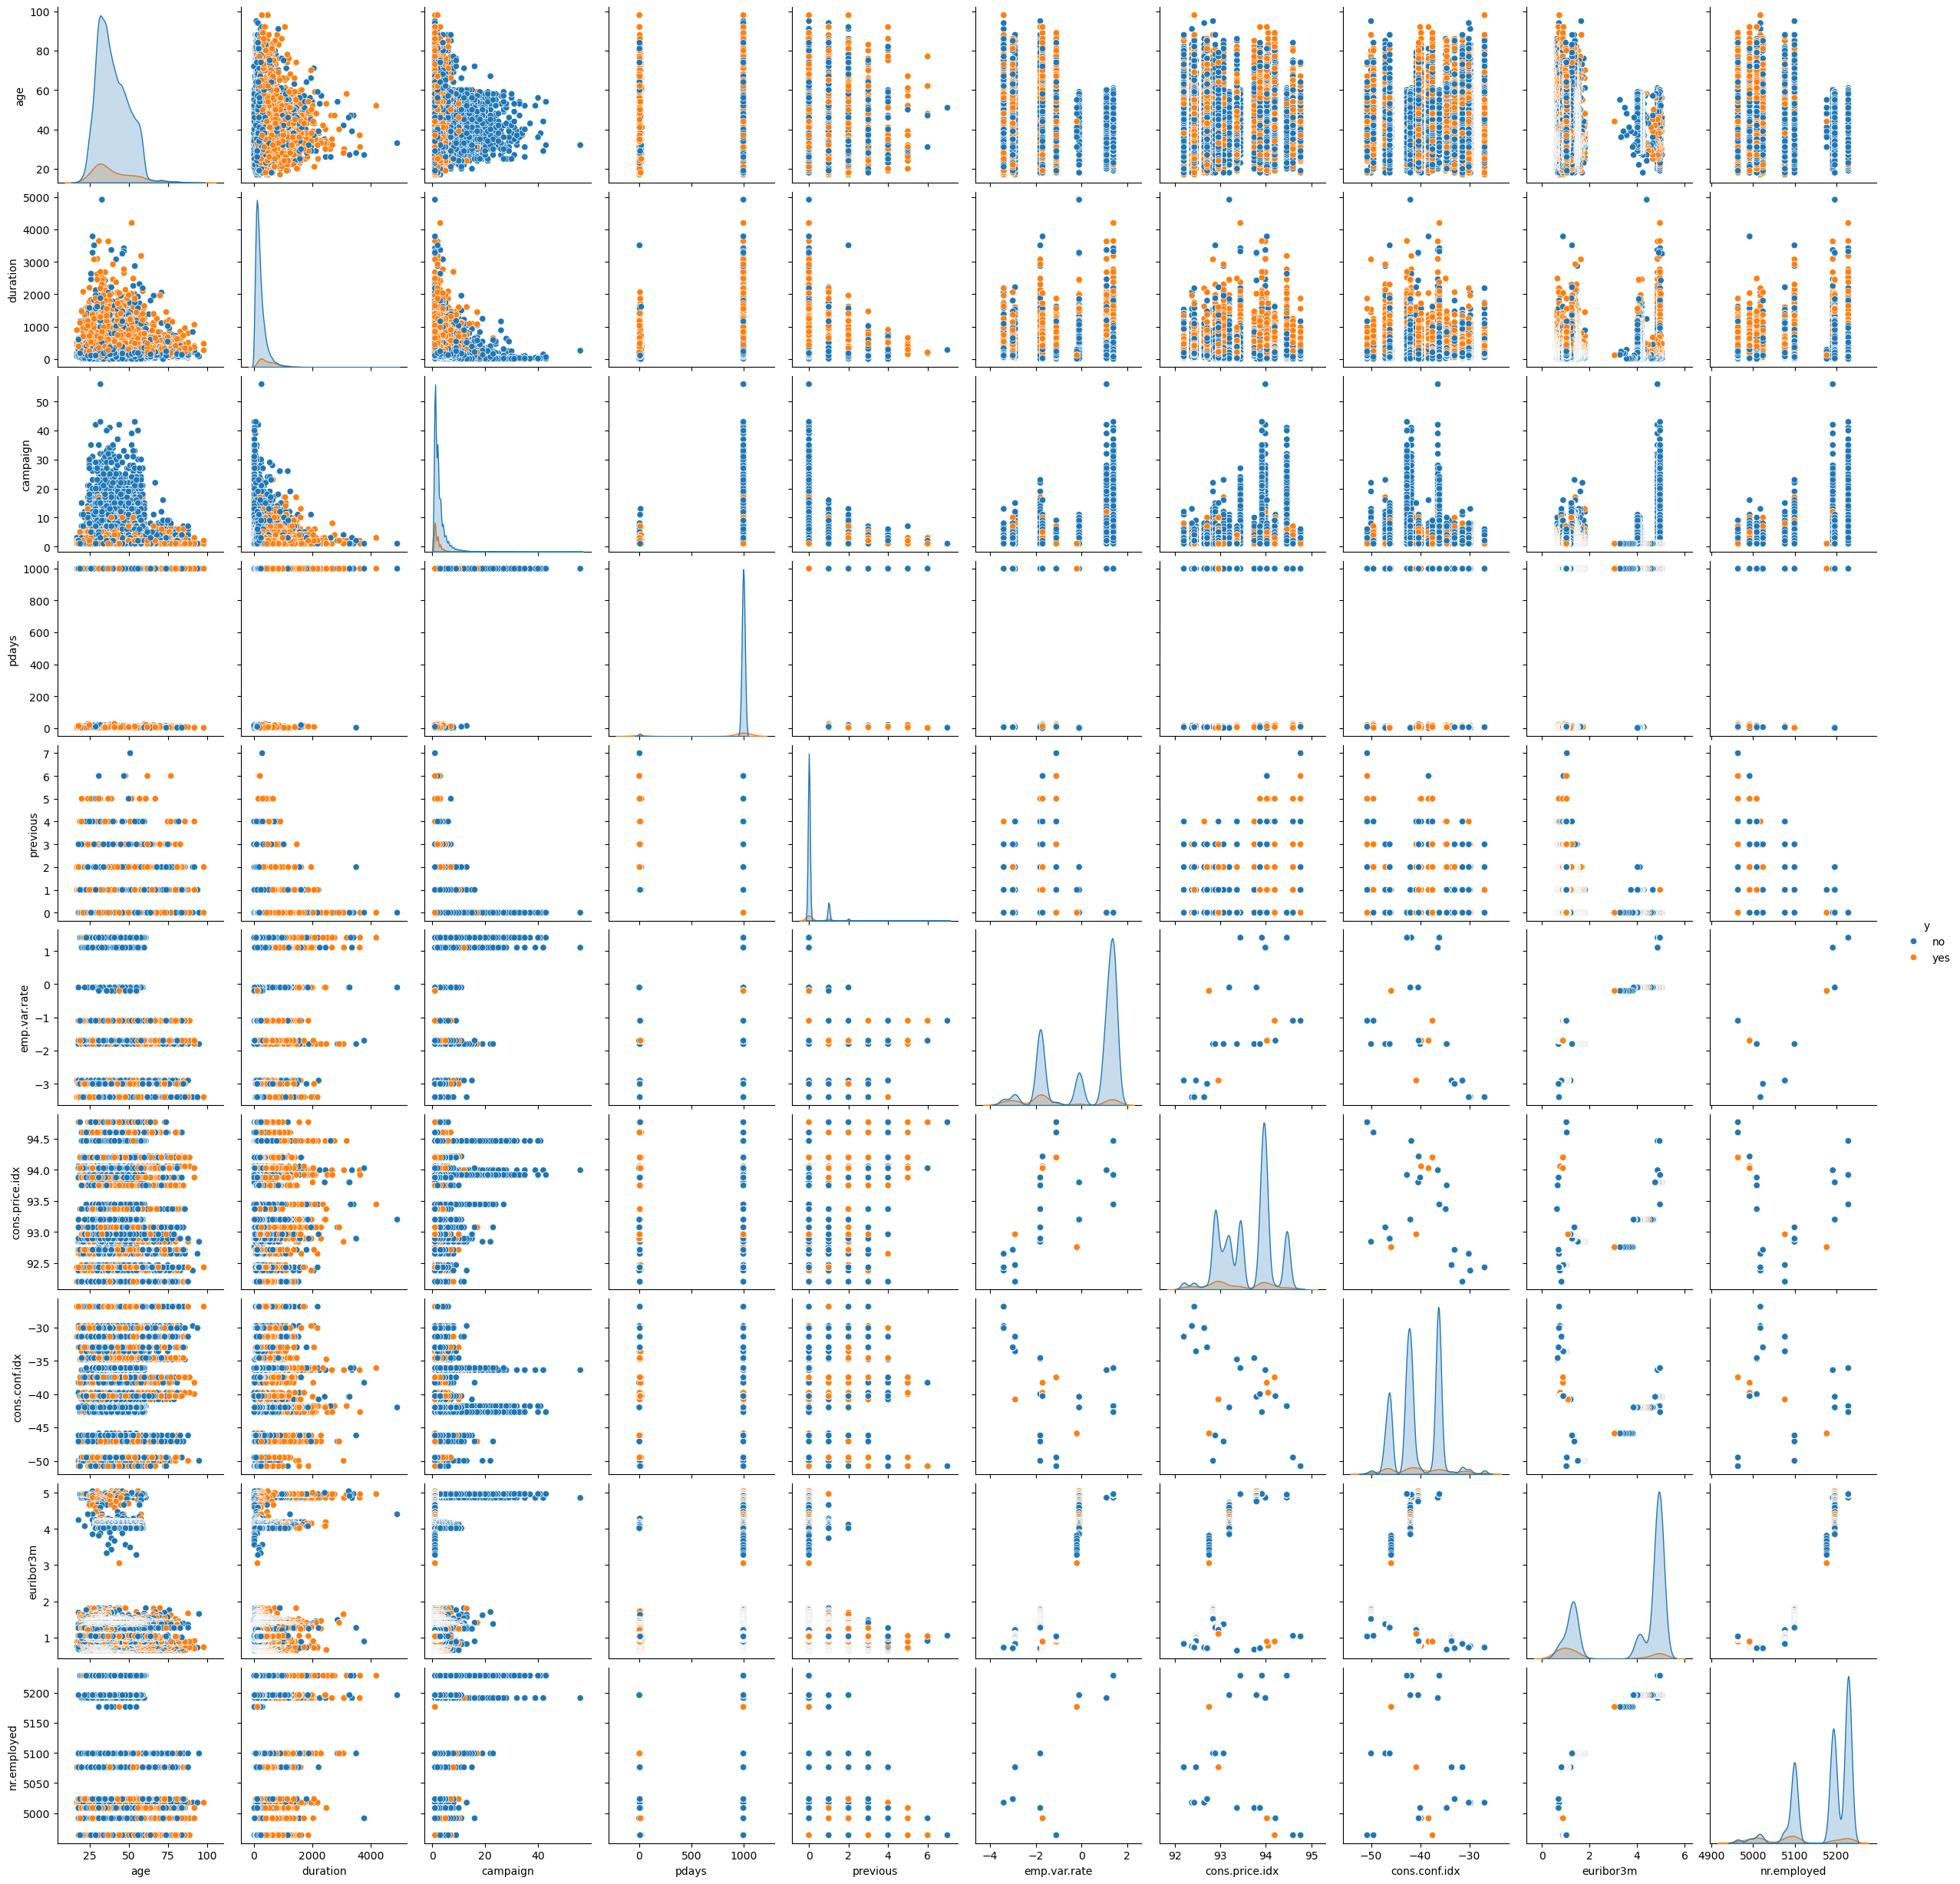

In [13]:
sns.pairplot(df, hue='y')
plt.show()

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [11]:
# try forcing Python to identify the data types
df = df.convert_dtypes()
print("Education count= ", df['education'].value_counts())
# --- Rnning above converted Object to String. Hence explicitly converting to numeric



Education count=  education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: count, dtype: Int64


In [20]:

from sklearn.model_selection import train_test_split

# -- Create X and Y and split the data before Feature encoding / engineering.
# -- NOTE : As stated above in "Understandding the Features" and also from above pairplot we see a strong correlation between duration and y.
# Hence lets remove the column for prediction purposes.
X = df.drop(columns=['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'duration', 'y'])
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
import category_encoders as ce
from sklearn.discriminant_analysis import StandardScaler

# --NOTE : Need to convert target var as well else JamesStein does not like it and errors "AttributeError: 'numpy.ndarray' object has no attribute 'groupby'"
y_train_enc = pd.get_dummies(y_train, drop_first=True, prefix='y')
y_test_enc = pd.get_dummies(y_test, drop_first=True, prefix='y')

# ---- boolean data : Use Dummy Encoder - Contact
contact_train_enc = pd.get_dummies(X_train['contact'], drop_first=True, prefix='contact')
contact_test_enc = pd.get_dummies(X_test['contact'], drop_first=True, prefix='contact')
X_train_enc = pd.concat([X_train, contact_train_enc], axis=1)
X_test_enc = pd.concat([X_test, contact_test_enc], axis=1)
X_train_enc = X_train_enc.drop(columns=['contact'])
X_test_enc = X_test_enc.drop(columns=['contact'])


# --- Ordinal encoder for
# education : 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown'
# Given 'unknown' is a tricky value, we use the avg value to fill this void. Avg is calculated using Ordinal values of other values
# Once we run the encoder without 'unknown', the value is eliminated from the data set, unfortunately. Hence running it as one operation.
education_map = {'basic.4y':4,'basic.6y':6,'basic.9y':9,'high.school':12,'illiterate':-1,'professional.course':14,'university.degree':16, 'unknown':11}
X_train_enc['education'] = X_train_enc['education'].map(education_map)
X_test_enc['education'] = X_test_enc['education'].map(education_map)

# unknown_val = int(X_test_enc['education'].mean())
# ed_all_map = {4:4, 6:6, 9:9, 12:12, -1:-1, 14:14, 16:16, 'unknown':unknown_val}
# X_train_enc['education'] = X_train_enc['education'].map(ed_all_map)
# numerical_cols = ['age', 'campaign', 'pdays', 'previous', 'education']
# std_scaler = StandardScaler()
# X_train_enc = std_scaler.fit_transform(X_train_enc[numerical_cols])
# X_test_enc = std_scaler.transform(X_test_enc[numerical_cols])

#Print unique values for each column
categorical_cols = ['job', 'marital', 'default', 'housing', 'loan', 'month', 'day_of_week', 'poutcome'] #, 'contact', 'education']


# James Stein encoder - job, marital, housing, loan, month, day_of_week, campaign, pdays, previous, poutcome
js_encoder = ce.JamesSteinEncoder(cols=categorical_cols, random_state=42)
js_encoder.fit(X_train_enc, y_train_enc)
X_train_enc = js_encoder.transform(X_train_enc)
X_test_enc = js_encoder.transform(X_test_enc)

X_train_enc.info()
print(y_train_enc.value_counts())


<class 'pandas.core.frame.DataFrame'>
Index: 32950 entries, 25611 to 10747
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                32950 non-null  Int64  
 1   job                32950 non-null  Float64
 2   marital            32950 non-null  Float64
 3   education          32950 non-null  int64  
 4   default            32950 non-null  Float64
 5   housing            32950 non-null  Float64
 6   loan               32950 non-null  Float64
 7   month              32950 non-null  Float64
 8   day_of_week        32950 non-null  Float64
 9   campaign           32950 non-null  Int64  
 10  pdays              32950 non-null  Int64  
 11  previous           32950 non-null  Int64  
 12  poutcome           32950 non-null  Float64
 13  contact_telephone  32950 non-null  boolean
dtypes: Float64(8), Int64(4), boolean(1), int64(1)
memory usage: 4.0 MB
y_yes
False    29238
True      3712
Name: count, dty

In [22]:
# -- encoding using Label Encoder and Target Encoder
from category_encoders import TargetEncoder
from sklearn.calibration import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler

le = LabelEncoder()
y_train_target_enc = le.fit_transform(y_train)
y_test_target_enc = le.transform(y_test)

categorical_cols = ['job', 'marital', 'default', 'housing', 'loan', 'month', 'day_of_week', 'poutcome', 'contact', 'education']
numerical_cols = ['age', 'campaign', 'pdays', 'previous']
col_transformer = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('categorical', TargetEncoder(), categorical_cols),
        #('target', LabelEncoder(), 'y')
    ]
)

print(type(y_train_target_enc))
X_train_target_enc = col_transformer.fit_transform(X_train, y_train_target_enc)
X_test_target_enc = col_transformer.transform(X_test)

cat_col_names = col_transformer.named_transformers_['categorical'].get_feature_names_out(categorical_cols)
all_col_names = list(numerical_cols) + list(cat_col_names)

X_train_target_enc_df = pd.DataFrame(X_train_target_enc, columns=all_col_names)
X_test_target_enc_df = pd.DataFrame(X_test_target_enc, columns=all_col_names)

print(X_train_target_enc_df.info())
X_train_target_enc_df.head()


<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32950 entries, 0 to 32949
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          32950 non-null  float64
 1   campaign     32950 non-null  float64
 2   pdays        32950 non-null  float64
 3   previous     32950 non-null  float64
 4   job          32950 non-null  float64
 5   marital      32950 non-null  float64
 6   default      32950 non-null  float64
 7   housing      32950 non-null  float64
 8   loan         32950 non-null  float64
 9   month        32950 non-null  float64
 10  day_of_week  32950 non-null  float64
 11  poutcome     32950 non-null  float64
 12  contact      32950 non-null  float64
 13  education    32950 non-null  float64
dtypes: float64(14)
memory usage: 3.5 MB
None


,age,campaign,pdays,previous,job,marital,default,housing,loan,month,day_of_week,poutcome,contact,education
0,0.863739,0.522981,0.196584,-0.350127,0.069211,0.101238,0.052017,0.109262,0.112712,0.101653,0.115579,0.088014,0.147025,0.076461
1,-0.289722,-0.203688,0.196584,1.653813,0.086207,0.101238,0.128850,0.109262,0.112712,0.101653,0.115579,0.144065,0.052981,0.138147
2,3.651268,-0.567023,0.196584,-0.350127,0.254758,0.101238,0.128850,0.109262,0.112712,0.092313,0.102466,0.088014,0.147025,0.103552
3,-0.385843,-0.203688,0.196584,-0.350127,0.128699,0.101238,0.128850,0.115567,0.112712,0.063482,0.102466,0.088014,0.052981,0.138147
4,1.824956,-0.203688,0.196584,-0.350127,0.254758,0.100952,0.128850,0.109262,0.112712,0.103838,0.116077,0.088014,0.147025,0.138147


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [ ]:
# Given its a good practice to split Train, Test data before Feature engineering, this step has been performed above at the beginning of feature engineering step.

y_train_enc = y_train_enc.to_numpy()
y_test_enc = y_test_enc.to_numpy()

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

For this we use the DummyClassifier as a baseline, a model that predicts using basic rules and not necessarily from learning from the data. Other models we use must beat this model's accuracy.

In [ ]:
import time
from sklearn.dummy import DummyClassifier
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

start_time = time.time()
dummy_classifier = DummyClassifier(strategy='stratified', random_state=42)
dummy_classifier.fit(X_train_enc, y_train_enc)
# X_train_transform = dummy_classifier.transform(X_train_enc)
y_test_preds = dummy_classifier.predict(X_test_enc)
end_time = time.time()

dummy_accuracy = accuracy_score(y_test_enc, y_test_preds)
dummy_precision = precision_score(y_test_enc, y_test_preds)
dummy_recall = recall_score(y_test_enc, y_test_preds)
dummy_f1score = f1_score(y_test_enc, y_test_preds)
dummy_conf_matrix = confusion_matrix(y_test_enc, y_test_preds)

print("Total time taken by Dummy classifier: ", end_time - start_time)
print('Dummy Classifier scores : \n'
      f'Accuracy: {dummy_accuracy}\n'
      f'Precision: {dummy_precision}\n'
      f'Recall: {dummy_recall}\n'
      f'F1 score: {dummy_f1score}\n')



Total time taken by Dummy classifier:  0.0035080909729003906
Dummy Classifier scores : 
Accuracy: 0.803714493809177
Precision: 0.12184412733260154
Recall: 0.11961206896551724
F1 score: 0.12071778140293637



#### Findings : 
<div class="alert alert-block alert-info">
The baseline model (Dummy Classifer) returns an Accuracy rate of ~80%, which is what we would expect our more sophisticated models to beat.
</div>

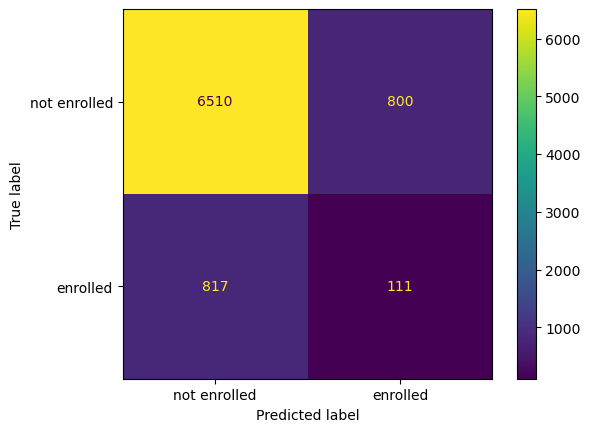

In [18]:
from cProfile import label
# import plotly.express as px
from sklearn.metrics import ConfusionMatrixDisplay


cmd = ConfusionMatrixDisplay(dummy_conf_matrix, display_labels=['not enrolled','enrolled'])
cmd.plot()

# dummy_conf_matrix_plot = ConfusionMatrixDisplay(dummy_conf_matrix)
# fig = px.imshow(dummy_conf_matrix)
# fig.update_layout()
# fig.update_xaxes(side='bottom') # move x axes tick labels to bottom
# fig.update_traces(text=dummy_conf_matrix, texttemplate="%{text}")
# fig.show()



### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [ ]:
from statistics import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

results = {}
y_train_enc.ravel()
y_test_enc.ravel()

le_start_time = time.time()
le_gridSearch = GridSearchCV(estimator = LogisticRegression(random_state=42),
                             param_grid={'C': [0.01, 0.1, 1, 10, 100]}
                             )
le_gridSearch.fit(X_train_enc, y_train_enc)
le_y_enc_pred = le_gridSearch.predict(X_test_enc)
le_end_time = time.time()

le_accuracy = accuracy_score(y_test_enc, le_y_enc_pred)
le_precision = precision_score(y_test_enc, le_y_enc_pred)
le_recall = recall_score(y_test_enc, le_y_enc_pred)
le_f1score = f1_score(y_test_enc, le_y_enc_pred)
le_conf_matrix = confusion_matrix(y_test_enc, le_y_enc_pred)

results['LogisticRegression'] = {
    'Accuracy Score': le_accuracy,
    'Precision Score': le_precision,
    'Recall': le_recall,
    'F1 Score': le_f1score,
    'Confusion Matrix': le_conf_matrix,
    'Best Params': le_gridSearch.best_estimator_,
    'Time Taken': (le_end_time - le_start_time)
}

Logistic Regression Accuracy score: 0.8977907259043457


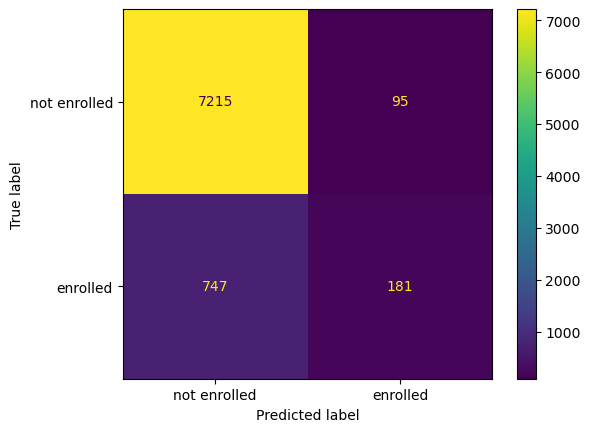

In [52]:
print(f"Logistic Regression Accuracy score: {results['LogisticRegression']['Accuracy Score']}")
cmd = ConfusionMatrixDisplay(le_conf_matrix, display_labels=['not enrolled','enrolled'])
cmd.plot()


### Problem 9: Score the Model

What is the accuracy of your model?

In [47]:

results_df = pd.DataFrame(results).T
results_df

,accuracy score,precision score,le_recall,le_f1score,le_best_params,Time Taken
LogisticRegression,0.897791,0.655797,0.195043,0.300664,"LogisticRegression(C=0.01, random_state=42)",5.286577


#### Findings : 
<div class="alert alert-block alert-info">
From an Accuracy standpoint the Logistic Regression provides close to 90% accuracy, which is much better than our baseline model's (Dummy) accuracy score of 80%. Hence LogisticRegression can be considered as a viable model.
</div>

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [30]:
# -- Declare models and their params

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


models = {
    'knn' : {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': range(1, 10)
        }
    },
    'decision_tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': range(1, 10)
        }
    },
    'SVM': {
        'model': SVC(coef0=1, random_state=42),
        'params': {
            'gamma': [0.1, 1.0, 10.0, 100.0]
        }
    }

}

In [ ]:
# Run the models without hyper param tuning

basic_results = {}
for model_name, model_params in models.items():
    model = model_params['model']
    start_time = time.time()

    model.fit(X_train_enc, y_train_enc)

    y_train_preds = model.predict(X_train_enc)
    y_test_preds = model.predict(X_test_enc)

    end_time = time.time()

    basic_results[model_name] = {
        'Train Time': (end_time - start_time),
        'Train Accuracy': accuracy_score(y_train_enc, y_train_preds),
        'Test Accuracy' : accuracy_score(y_test_enc, y_test_preds)
    }

basic_results_df = pd.DataFrame(basic_results).T.sort_values(by='Test Accuracy', ascending=False)
basic_results_df

/Users/sambapedapalli/work/code/ml-ai-learn/ucberkeley/ml-ai-class/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/sambapedapalli/work/code/ml-ai-learn/ucberkeley/ml-ai-class/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Train Time,Train Accuracy,Test Accuracy
SVM,13.273954,0.897481,0.897669
knn,1.339854,0.907132,0.890750
decision_tree,0.086711,0.993323,0.828356


#### Findings / Result :
<div class="alert alert-block alert-info">
For comparison, we will primarily focus on Test Accuracy since this param essentially tells us how the model would perform on unseen data.

All the above models did significantly better than the Dummy Classifier. But in terms of Accuracy, LogisticRegression with hyper parameter tuning did better than any of these 3 models which were not tuned. So may not be apples to apples comparison. 

But in terms of time, Decision Tree took the minimal time while its Test accuracy was the lowest. For a good balance between Train time and Test Accuracy, "knn" model seems to be the best option given the Accuracy is almost same as SVM but takes approximately one-twelth the time of SVM model.
</div>

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [ ]:
# - check the correlation among the features - Categorical vars encoded using JamesStein
X_train_enc.corr()

,age,job,marital,education,default,housing,loan,month,day_of_week,campaign,pdays,previous,poutcome,contact_telephone
age,1.000000,0.138628,-0.409515,-0.178600,-0.169001,-0.002850,0.004695,0.087505,-0.025045,0.003302,-0.032011,0.020670,0.031738,0.007760
job,0.138628,1.000000,0.128140,0.264812,0.122030,0.014741,-0.007474,0.207810,-0.003644,-0.013536,-0.135150,0.124180,0.129242,-0.104553
marital,-0.409515,0.128140,1.000000,0.175490,0.125461,0.020106,-0.005735,0.044468,0.012704,-0.000346,-0.046016,0.053335,0.047322,-0.071461
education,-0.178600,0.264812,0.175490,1.000000,0.231302,0.023624,-0.014171,0.088150,-0.009955,-0.002915,-0.040451,0.038578,0.042074,-0.114239
default,-0.169001,0.122030,0.125461,0.231302,1.000000,0.019003,-0.006338,0.124177,0.010478,-0.037412,-0.081509,0.106398,0.089998,-0.136839
housing,-0.002850,0.014741,0.020106,0.023624,0.019003,1.000000,-0.035478,0.034794,0.002029,-0.013682,-0.013121,0.027201,0.017953,-0.082150
loan,0.004695,-0.007474,-0.005735,-0.014171,-0.006338,-0.035478,1.000000,0.002705,0.007889,-0.005984,-0.000448,0.002606,-0.000583,0.022010
month,0.087505,0.207810,0.044468,0.088150,0.124177,0.034794,0.002705,1.000000,-0.013450,-0.057668,-0.225750,0.219814,0.231326,-0.228660
day_of_week,-0.025045,-0.003644,0.012704,-0.009955,0.010478,0.002029,0.007889,-0.013450,1.000000,-0.019919,-0.007324,0.000254,0.008145,-0.010667
campaign,0.003302,-0.013536,-0.000346,-0.002915,-0.037412,-0.013682,-0.005984,-0.057668,-0.019919,1.000000,0.053795,-0.079051,-0.063104,0.074217


In [ ]:
# -- check the correlation among features - Categorical vars encoded using Target Encoder
X_train_target_enc_df.corr()

# -- NOTE : Correlation between the 2 tables (James Stein encoded and Target Encoded) are largely similar.
# One diff is Education.  In former cases, where Ordinal Encoder was used with values manually assigned to each unique value, corr = -0.1786
# In case of latter, where Target Encoder was used to encode the values, corr = -0.013653.

,age,campaign,pdays,previous,job,marital,default,housing,loan,month,day_of_week,poutcome,contact,education
age,1.000000,0.003302,-0.032011,0.020670,0.144805,-0.409434,-0.169037,-0.002850,0.004695,0.082934,-0.025080,0.031738,-0.007760,-0.013653
campaign,0.003302,1.000000,0.053795,-0.079051,-0.015997,-0.000332,-0.037557,-0.013682,-0.005984,-0.061849,-0.019886,-0.063104,-0.074217,0.002246
pdays,-0.032011,0.053795,1.000000,-0.589601,-0.137266,-0.046015,-0.081502,-0.013121,-0.000448,-0.231359,-0.007390,-0.943982,-0.116561,-0.057613
previous,0.020670,-0.079051,-0.589601,1.000000,0.128710,0.053342,0.106547,0.027201,0.002606,0.229017,0.000242,0.635991,0.212673,0.044929
job,0.144805,-0.015997,-0.137266,0.128710,1.000000,0.124854,0.101061,0.012769,-0.006188,0.201937,-0.002461,0.131193,0.095942,0.243747
marital,-0.409434,-0.000332,-0.046015,0.053342,0.124854,1.000000,0.125354,0.020095,-0.005736,0.046683,0.012762,0.047325,0.071461,0.126589
default,-0.169037,-0.037557,-0.081502,0.106547,0.101061,0.125354,1.000000,0.018899,-0.006247,0.122252,0.010627,0.090033,0.137128,0.138818
housing,-0.002850,-0.013682,-0.013121,0.027201,0.012769,0.020095,0.018899,1.000000,-0.035478,0.032734,0.002169,0.017953,0.082150,0.014228
loan,0.004695,-0.005984,-0.000448,0.002606,-0.006188,-0.005736,-0.006247,-0.035478,1.000000,0.003259,0.007842,-0.000583,-0.022010,-0.012171
month,0.082934,-0.061849,-0.231359,0.229017,0.201937,0.046683,0.122252,0.032734,0.003259,1.000000,-0.012228,0.238082,0.196140,0.106865


#### Using Label and Target Encoders for Categorical data

In [ ]:
# Run the model using Label and Target Encoded features
target_results = {}
for model_name, model_params in models.items():
    model = model_params['model']
    start_time = time.time()

    # gsearch = GridSearchCV(estimator=model,
    #                        scoring='accuracy',
    #                        cv=5,
    #                        verbose=1)
    model.fit(X_train_target_enc, y_train_target_enc)

    y_train_preds = model.predict(X_train_target_enc)
    y_test_preds = model.predict(X_test_target_enc)

    end_time = time.time()

    target_results[model_name] = {
        'Train Time': (end_time - start_time),
        'Train Accuracy': accuracy_score(y_train_enc, y_train_preds),
        'Test Accuracy' : accuracy_score(y_test_enc, y_test_preds)
    }

target_results_df = pd.DataFrame(target_results).T.sort_values(by='Test Accuracy', ascending=False)
target_results_df

,Train Time,Train Accuracy,Test Accuracy
SVM,19.000521,0.898179,0.897548
knn,1.033488,0.909803,0.890629
decision_tree,0.081325,0.993323,0.835033


#### Findings
<div class="alert alert-block alert-info">
Comparing above against previous run, Decision Tree Test Accuracy improved marginally, else the numbers are pretty similar 
</div>

#### Using Hyper Parameter Tuning

In [ ]:
# Running for features encoded using Label Encoder and Target Encoder.
tune_results = {}
for model_name, model_params in models.items():
    model = model_params['model']
    start_time = time.time()

    gsearch = GridSearchCV(estimator=model,
                           param_grid=model_params['params'],
                           scoring='accuracy',
                           cv=5,
                           verbose=1)
    gsearch.fit(X_train_target_enc, y_train_target_enc)

    y_train_preds = gsearch.predict(X_train_target_enc)
    y_test_preds = gsearch.predict(X_test_target_enc)

    end_time = time.time()

    tune_results[model_name] = {
        'Train Time': (end_time - start_time),
        'Train Accuracy': accuracy_score(y_train_enc, y_train_preds),
        'Test Accuracy' : accuracy_score(y_test_enc, y_test_preds),
        'Confusion Matrix' : confusion_matrix(y_test_enc, y_test_preds),
        'Best Params': gsearch.best_estimator_
    }

tune_results_df = pd.DataFrame(tune_results).T.drop(columns=['Confusion Matrix']).sort_values(by='Test Accuracy', ascending=False)
tune_results_df


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits


,Train Time,Train Accuracy,Test Accuracy,Best Params
SVM,252.281763,0.897724,0.897912,"SVC(coef0=1, gamma=0.1, random_state=42)"
decision_tree,0.919277,0.897481,0.897669,"DecisionTreeClassifier(max_depth=1, random_sta..."
knn,8.392093,0.902519,0.894877,KNeighborsClassifier(n_neighbors=9)


### Findings - Conclusion
<div class="alert alert-block alert-info">
After Hyperparameter Tuning, Decision Tree performs significantly better although marginally less Accurate the SVM. But given the time take is less than 1 sec, it would be the model of choice.
</div>

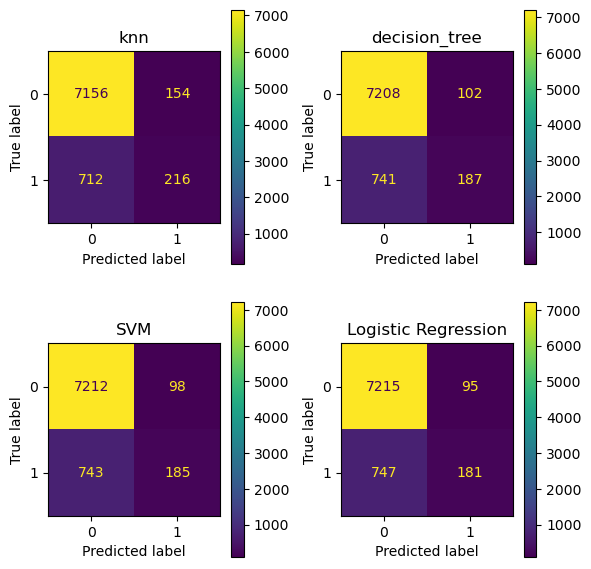

In [ ]:
# Plot
import math

# add Logistic Regression results to the results
tune_results['Logistic Regression'] = {
    'Train Time': results['LogisticRegression']['Time Taken'],
    'Train Accuracy': results['LogisticRegression']['Accuracy Score'],
    'Confusion Matrix' : results['LogisticRegression']['Confusion Matrix'],
    'Best Params': results['LogisticRegression']['Best Params'],
}

# calc the # of rows and columns
n_models = len(tune_results)
n_cols = 2 # default for now
n_rows = math.ceil(n_models / n_cols)

fig, axes = plt.subplots(nrows=n_rows, ncols = n_cols, figsize=(n_cols * 3, n_rows*3))
axes = axes.flatten()

# One way to plot it
for idx, (model_name, metrics) in enumerate(tune_results.items()):
    conf_matrix = metrics['Confusion Matrix']
    disp = ConfusionMatrixDisplay(conf_matrix)
    disp.plot(ax=axes[idx])
    axes[idx].set_title(model_name)
plt.tight_layout()


##### Questions

1. How would the model perform if other hyperparam tuning Estimators(other than GridSearchCV) such as RandomSearch or HalvingGridSearchCV or HalvingRandomSearchCV were used ?
2. Can we run PCA as part of Feature Engineering ? What would the outcome look like ?